In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, yaml, subprocess, itertools, sparse

who_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")
variant_mapping = pd.read_csv("../data/v1_to_v2_variants_mapping.csv", usecols=["gene_name", "variant", "raw_variant_mapping_data.variant_category"])
variant_mapping.columns = ["gene", "V1", "V2"]
variant_mapping["mutation"] = variant_mapping["gene"] + "_" + variant_mapping["V2"]

# combine with the new names to get a dataframe with the confidence leve,s and variant mappings between 2021 and 2022
who_variants_combined = who_variants.merge(variant_mapping[["V1", "mutation"]], left_on="variant", right_on="V1", how="inner")
del who_variants_combined["variant"]
assert len(set(who_variants_combined["V1"]).symmetric_difference(set(who_variants["variant"]))) == 0
del who_variants

# pd.set_option('display.float_format', lambda x: '%.4f' % x)
samples_summary = pd.read_csv("../data/samples_summary.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

import warnings
warnings.filterwarnings(action='ignore')

# Combined Analysis Files

In [2]:
def final_processing_and_validation(drug, drug_who_abbr, who_variants_combined):
    '''
    Functions for processing outputs before sending to everyone else.
    
    1. Remove principal components (will describe them separately)
    2. Add LOF to the predicted_effect column for pooled LOF mutations
    3. Remove the logistic regression coefficient columns (preferred to work with odds ratios)
    4. Any other column renaming or dropping for clarity
    5. More checking that things make sense
    '''
    
    analysis_df = pd.read_csv(os.path.join(analysis_dir, drug, "final_analysis_with_univariate.csv"))
    analysis_df.rename(columns={"variant": "mutation"}, inplace=True)
    # remove coefficients, keep only odds ratios since they are redundant
    analysis_df = analysis_df[analysis_df.columns[~analysis_df.columns.str.contains("coef")]]
    
    # add in the WHO 2021 catalog confidence levels, using the dataframe with 2021 to 2022 mapping
    if drug_who_abbr in who_variants_combined["drug"].values:
        analysis_df = analysis_df.merge(who_variants_combined.query("drug==@drug_who_abbr"), on="mutation", how="left")
    
    # add significance annotations
    analysis_df.loc[(analysis_df["Tier"] == 1) &
                    (analysis_df["Phenos"] == 'WHO') &
                    (analysis_df["unpooled"] == 0) &
                    (analysis_df["synonymous"] == 0) &
                    (analysis_df["HET"] == 'DROP') &
                    (analysis_df["BH_pval"] < 0.05), "Significant"
                   ] = 1

    analysis_df.loc[~((analysis_df["Tier"] == 1) &
                      (analysis_df["Phenos"] == 'WHO') &
                      (analysis_df["unpooled"] == 0) &
                      (analysis_df["synonymous"] == 0) & 
                      (analysis_df["HET"] == 'DROP')
                     ) & (analysis_df["BH_pval"] < 0.01), "Significant"
                    ] = 1

    analysis_df["Significant"] = analysis_df["Significant"].fillna(0).astype(int)
    
    # count the number of significant principal components, then remove all of them
    print(f'{len(analysis_df.loc[(analysis_df["mutation"].str.contains("PC")) & (analysis_df["Significant"]==1)])} significant principal components for {drug}')
    analysis_df = analysis_df.loc[~analysis_df["mutation"].str.contains("PC")]
    
    # check that these columns are not NaN, then convert to ints for clarity
    assert len(analysis_df.dropna(subset=['Tier', 'Phenos', 'unpooled', 'synonymous', 'HET'])) == len(analysis_df)
    analysis_df[['Tier', 'unpooled', 'synonymous']] = analysis_df[['Tier', 'unpooled', 'synonymous']].astype(int)
    
    # predicted effect should not be NaN for anything. position is NaN only for the pooled LOF mutations
    assert len(analysis_df.loc[pd.isnull(analysis_df["predicted_effect"])]) == 0
    assert len(analysis_df.loc[pd.isnull(analysis_df["position"]) & ~(analysis_df["predicted_effect"]).isin(["lof", "inframe"])]) == 0
    assert len(analysis_df.query("Significant==1 & BH_pval > 0.01 & BH_pval < 0.05")[["mutation", 'Tier', 'Phenos', 'unpooled', 'synonymous', 'HET']].drop_duplicates(['Tier', 'Phenos', 'unpooled', 'synonymous', 'HET'])) == 1
        
    # check confidence intervals. LB ≤ var ≤ UB, and no confidence intervals have width 0 
    # TODO: figure out numerical precision issue where it looks like i.e. 1 ≠ 1
    # this is why var = 0 and var = 1 are excluded from this check
    for var in ["PPV", "NPV", "Sens", "Spec", "LR+", "LR-"]:
        assert len(analysis_df.loc[(~analysis_df[var].isin([0, 1])) & (analysis_df[var] < analysis_df[f"{var}_LB"])]) == 0
        assert len(analysis_df.loc[(~analysis_df[var].isin([0, 1])) & (analysis_df[var] > analysis_df[f"{var}_UB"])]) == 0
        
        width = analysis_df[f"{var}_UB"] - analysis_df[f"{var}_LB"]
        assert np.min(width) > 0
    
    # if LR+ = inf, then the lower bound may be NaN, so replace with inf. Only do for the non-AF variants because AF variants should not have univariate stats
    # analysis_df.loc[(analysis_df["HET"]=='DROP') & (pd.isnull(analysis_df["LR+_LB"])), "LR+_LB"] = np.inf
    
    # check that every variant is present in at least 1 isolate
    assert analysis_df.Num_Isolates.min() > 0
    
    # check that there are no NaNs in the univariate statistics (will be NaN for HET = AF). Don't include LR+ upper and lower bounds because they can be NaN if LR+ = inf
    assert len(analysis_df.query("HET=='DROP'")[pd.isnull(analysis_df[['Num_Isolates', 'Total_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'NPV', 'Sens', 'Spec', 'LR+', 'LR-',
                                   'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB', 'Spec_UB', 'LR-_LB', 'LR-_UB']]).any(axis=1)]) == 0

    # reorder columns
    analysis_df.rename(columns={"confidence": "confidence_WHO_2021"}, inplace=True)
    analysis_df = analysis_df[['mutation', 'predicted_effect', 'position', 'confidence_WHO_2021', 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'Bonferroni_pval', "Significant",
                               'Tier', 'Phenos', 'unpooled', 'synonymous', 'HET', 
                               'Num_Isolates', 'Total_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'NPV', 'Sens', 'Spec', 'LR+', 'LR-',
                               'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB', 'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB', 
                              ]]
            
    return analysis_df.drop_duplicates("mutation").sort_values("Odds_Ratio", ascending=False).reset_index(drop=True)

# Write Final Dataframes to an Excel File

In [3]:
drug_abbr_dict = {"Amikacin": "AMI",
                  "Bedaquiline": "BDQ",
                  "Capreomycin": "CAP",
                  "Clofazimine": "CFZ",
                  "Delamanid": "DLM",
                  "Ethambutol": "EMB",
                  "Ethionamide": "ETH",
                  "Isoniazid": "INH",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Pyrazinamide": "PZA",
                  "Rifampicin": "RIF",
                  "Streptomycin": "STM"
}

finished_drugs = ["Delamanid", "Bedaquiline", "Clofazimine", "Ethionamide", "Linezolid",
                  "Moxifloxacin", "Capreomycin", "Amikacin", "Pyrazinamide", "Kanamycin", "Levofloxacin",
                  "Streptomycin", 
                  # "Rifampicin", "Isoniazid", "Ethambutol"
                 ]
drug_analyses = {}
for drug in np.sort(finished_drugs):
    drug_analyses[drug] = final_processing_and_validation(drug, drug_abbr_dict[drug], who_variants_combined)
    
print(f"\nFinished {len(drug_analyses)} drugs!")

# write results to an Excel file, where each sheet name is a drug
with pd.ExcelWriter("../results/Farhat_logReg_analysis.xlsx") as file:
   
    for key, val in drug_analyses.items():
        val.to_excel(file, sheet_name=key, index=False)

1 significant principal components for Amikacin
2 significant principal components for Bedaquiline
1 significant principal components for Capreomycin
2 significant principal components for Clofazimine
1 significant principal components for Delamanid
0 significant principal components for Ethionamide
2 significant principal components for Kanamycin
2 significant principal components for Levofloxacin
1 significant principal components for Linezolid
2 significant principal components for Moxifloxacin
4 significant principal components for Pyrazinamide
3 significant principal components for Streptomycin

Finished 12 drugs!


# Compare Odds Ratios and p-values between the WHO vs. WHO + ALL Analyses 

## Write to another Excel file

In [6]:
def make_WHO_vs_ALL_dataframe(drug):
    
    analysis_paths = ["tiers=1/phenos=WHO/dropAF_noSyn",
                      "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=WHO/dropAF_withSyn",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=WHO/dropAF_withSyn",
                      "tiers=1/phenos=ALL/dropAF_noSyn",
                      "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=ALL/dropAF_withSyn",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=ALL/dropAF_withSyn",
                      "tiers=1/phenos=WHO/encodeAF_noSyn",
                      "tiers=1+2/phenos=WHO/encodeAF_noSyn",
                      "tiers=1/phenos=ALL/encodeAF_noSyn",
                      "tiers=1+2/phenos=ALL/encodeAF_noSyn",
    ]
    
    combined_dfs_dict = {}

    for model_path in analysis_paths:
        if "ALL" in model_path:

            # equivalent who path
            who_path = model_path.replace("ALL", "WHO")

            all_df = pd.read_csv(os.path.join(analysis_dir, drug, model_path, "model_analysis.csv"))
            all_df.columns = [col + "_ALL" if col != "variant" else col for col in all_df.columns]
            who_df = pd.read_csv(os.path.join(analysis_dir, drug, who_path, "model_analysis.csv"))
            
            combined = who_df.merge(all_df, on="variant")
            combined = combined[combined.columns[~combined.columns.str.contains("|".join(["coef"]))]]
            assert len(set(combined.variant).symmetric_difference(who_df.variant)) == 0

            combined["Tier"] = [2 if "+2" in model_path else 1][0]
            combined["unpooled"] = int("unpooled" in model_path)
            combined["synonymous"] = int("withSyn" in model_path)
            combined["HET"] = ["DROP" if "drop" in model_path else "AF"][0]
            
            # add significance annotations. For the ALL dataframe, FDR < 0.01
            combined.loc[combined["BH_pval_ALL"] < 0.01, "Significant_ALL"] = 1
            combined["Significant_ALL"] = combined["Significant_ALL"].fillna(0).astype(int)

            combined.loc[(combined["Tier"] == 1) &
                        (combined["unpooled"] == 0) &
                        (combined["synonymous"] == 0) &
                        (combined["HET"] == 'DROP') &
                        (combined["BH_pval"] < 0.05), "Significant"
                       ] = 1
            combined.loc[~((combined["Tier"] == 1) &
                          (combined["unpooled"] == 0) &
                          (combined["synonymous"] == 0) & 
                          (combined["HET"] == 'DROP')
                         ) & (combined["BH_pval"] < 0.01), "Significant"
                        ] = 1
            combined["Significant"] = combined["Significant"].fillna(0).astype(int)

            combined_dfs_dict[model_path] = combined

    combined_all = pd.concat(list(combined_dfs_dict.values())).drop_duplicates(subset=["variant"], keep="first")
    combined_all.rename(columns={"variant": "mutation"}, inplace=True)
    
    # add predicted effect, position, and WHO 2021 confidence grading
    combined_all = combined_all.merge(drug_analyses[drug][["mutation", "predicted_effect", "position", "confidence_WHO_2021"]], on="mutation")
    
    return combined_all[["mutation", "predicted_effect", "position", "confidence_WHO_2021", 'Odds_Ratio', 'OR_LB','OR_UB', 'pval', 'BH_pval', 'Bonferroni_pval', 'Significant', 'Odds_Ratio_ALL', 'OR_LB_ALL', 'OR_UB_ALL', 
                         'pval_ALL', 'BH_pval_ALL', 'Bonferroni_pval_ALL', 'Significant_ALL', 'Tier', 'unpooled', 'synonymous', 'HET']].sort_values("Odds_Ratio", ascending=False)

In [7]:
who_all_comparisons = {}

for drug in np.sort(finished_drugs):
    who_all_comparisons[drug] = make_WHO_vs_ALL_dataframe(drug)
    
# write results to an Excel file, where each sheet name is a drug
with pd.ExcelWriter("../results/Farhat_WHO_ALL_comparison.xlsx") as file:
   
    for key, val in who_all_comparisons.items():
        val.to_excel(file, sheet_name=key, index=False)

# Volcano Plots

In [123]:
def volcano_plot(df, drug, plot_x="log-OR", plot_y="log_neg_log_pval", pval_col="BH_pval", color_col="Significant", or_thresh=0, saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. All of these can be plotted. 
    
    '''
    plot_df = df.copy()
    lower, upper = 1 - or_thresh, 1 + or_thresh
    plot_df = plot_df.query("Odds_Ratio < @lower | Odds_Ratio > @upper")
    
    if or_thresh > 0:
        print(f"Excluded {len(df) - len(plot_df)} variants from plotting")
    
    if plot_df[pval_col].min() == 0:
        second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
        plot_df[pval_col] += second_smallest
        
    plot_df["neg_log_pval"] = -np.log(plot_df[pval_col])
    plot_df["log_neg_log_pval"] = np.log(plot_df["neg_log_pval"])
    plot_df["log-OR"] = np.log(plot_df["Odds_Ratio"])
    plot_df.loc[(plot_df["Tier"]==1) & 
                (plot_df["Phenos"]=='WHO') & 
                (plot_df["unpooled"]==0) & 
                (plot_df["synonymous"]==0) & 
                (plot_df["HET"]=='DROP'), 
                "Analysis"] = "Primary"
    plot_df["Analysis"] = plot_df["Analysis"].fillna("Secondary")
        
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.scatterplot(data=plot_df.query("Analysis=='Primary'"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=0.8,
                    hue="Significant", 
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette={1:sns.color_palette("tab10").as_hex()[0], 0:"lightgray"},
                    #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                    ax=ax[0]
                   )
    sns.scatterplot(data=plot_df.query("Analysis=='Secondary'"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=0.8,
                    hue="Significant",
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette={1:sns.color_palette("tab10").as_hex()[0], 0:"lightgray"},
                    #palette={"Primary": sns.color_palette("Set2").as_hex()[2], "Secondary": sns.color_palette("Set2").as_hex()[1]},
                    ax=ax[1]
                   )
    
    if plot_x[:3] == 'log':
        center = 0
    else:
        center = 1
      
    for axis in ax:
        if plot_y[:3] == 'log':
            axis.set_ylabel("Log(-Log(p-value))")
        else:
            axis.set_ylabel("-Log(p-value)")

    bound_0 = np.max(np.abs(plot_df.query("Analysis=='Primary'")[plot_x] - center))*1.1
    bound_1 = np.max(np.abs(plot_df.query("Analysis=='Secondary'")[plot_x] - center))*1.1
        
    for axis in ax:
        axis.set_xlabel("Regression Log-Odds")
        axis.legend().set_visible(False)
        
    ax[0].set_title(f"Primary Analysis Results for {drug}")
    ax[0].set_xlim(center - bound_0, center + bound_0)
    
    ax[1].set_title(f"Secondary Analysis Results for {drug}")
    ax[1].set_xlim(center - bound_1, center + bound_1)

    sns.despine()
    
    if saveFig is not None:
        plt.savefig(saveFig, dpi=300, bbox_inches="tight")
    else:
        plt.show()
        
    return plot_df

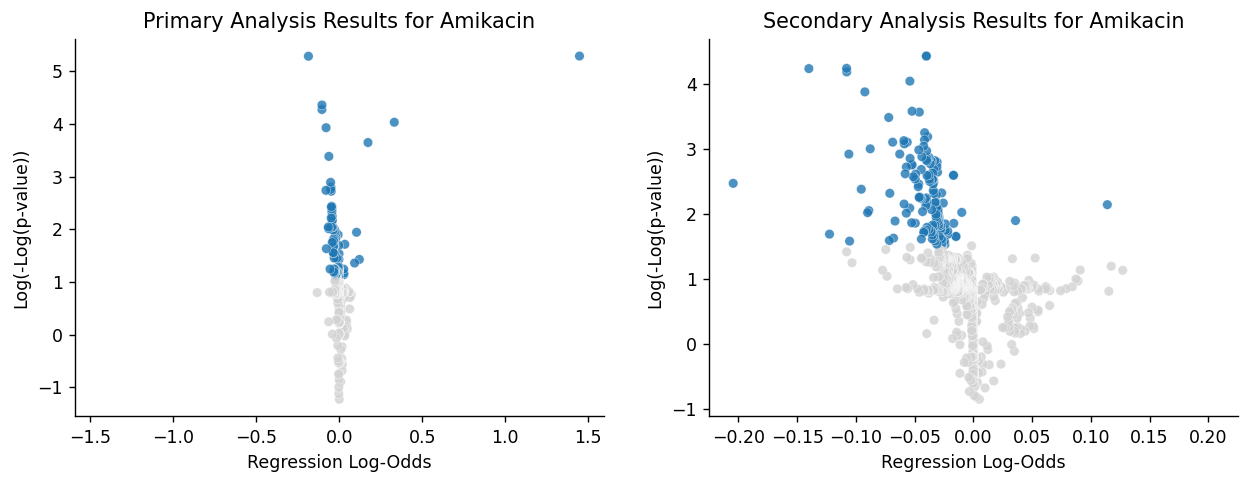

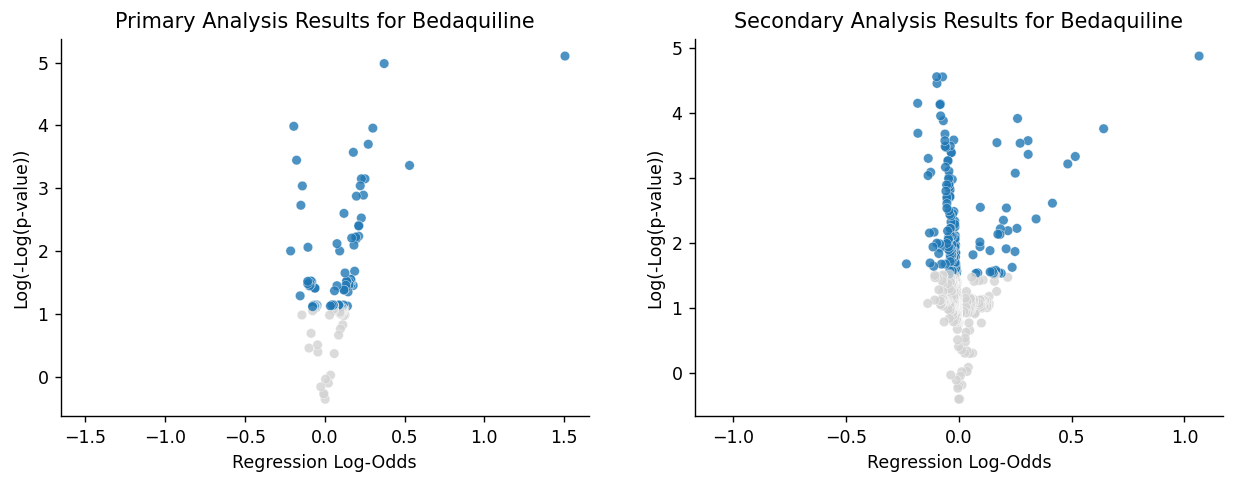

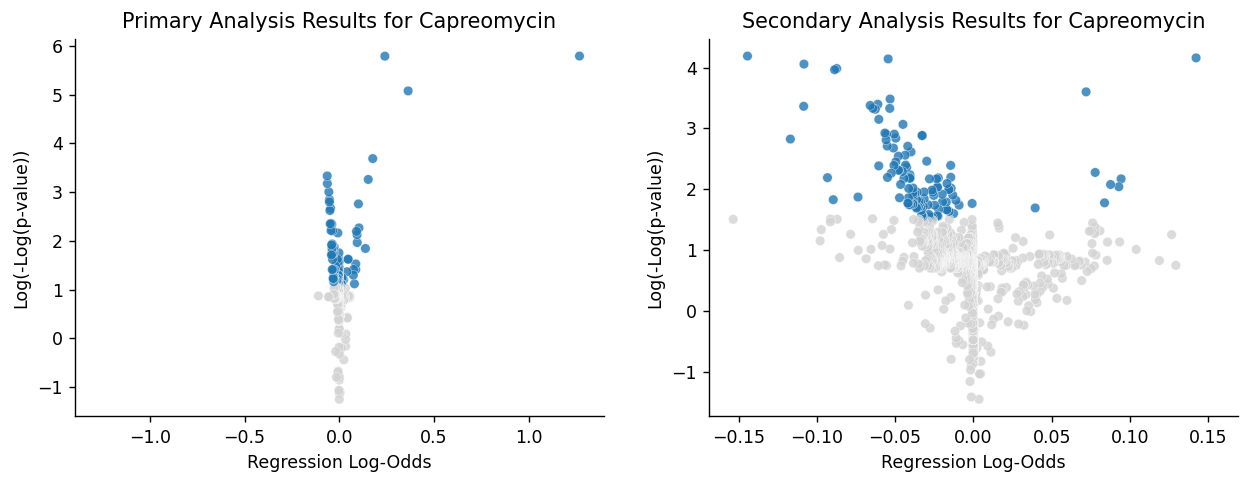

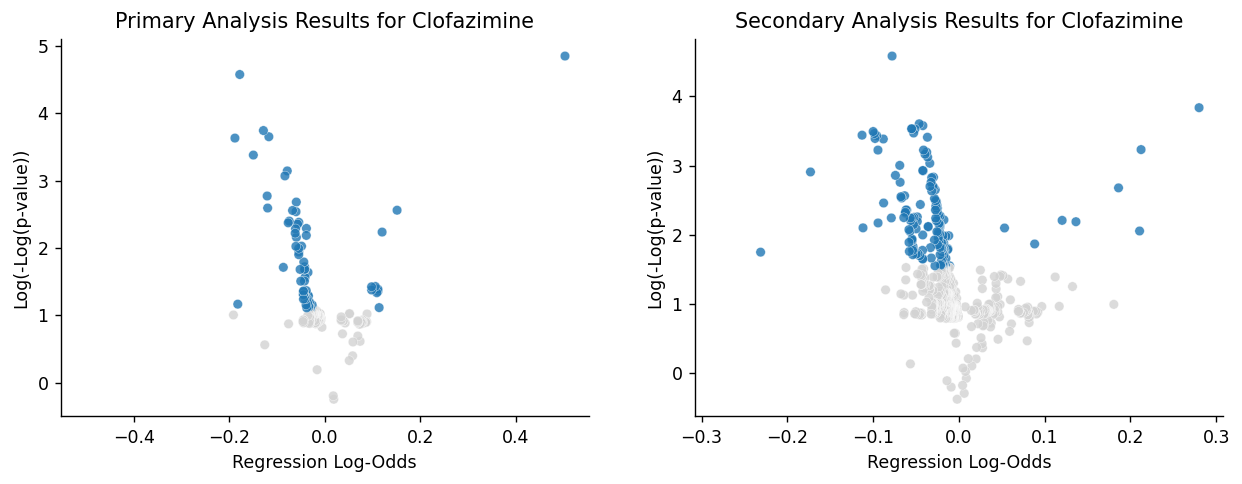

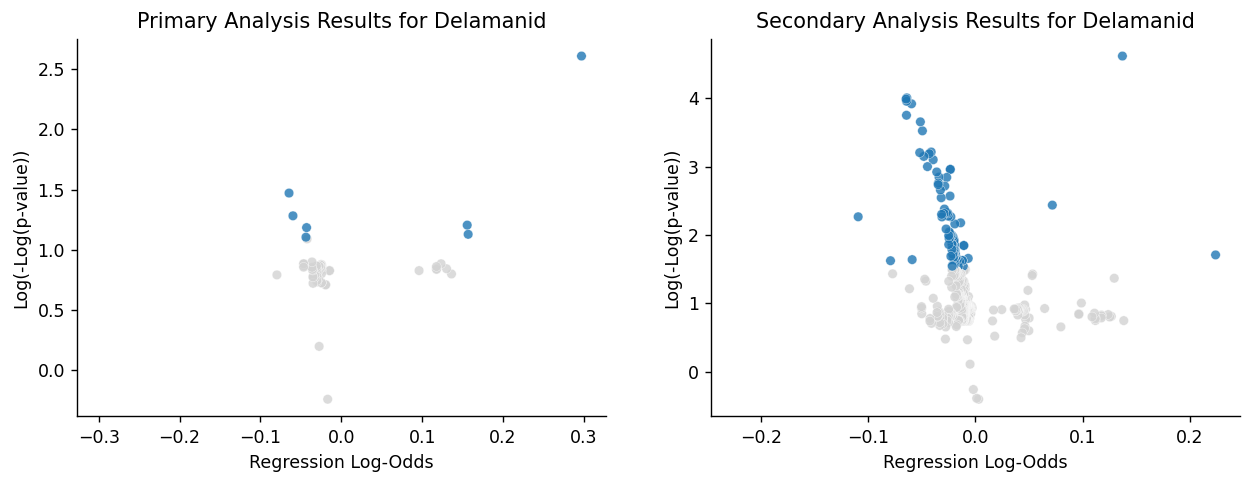

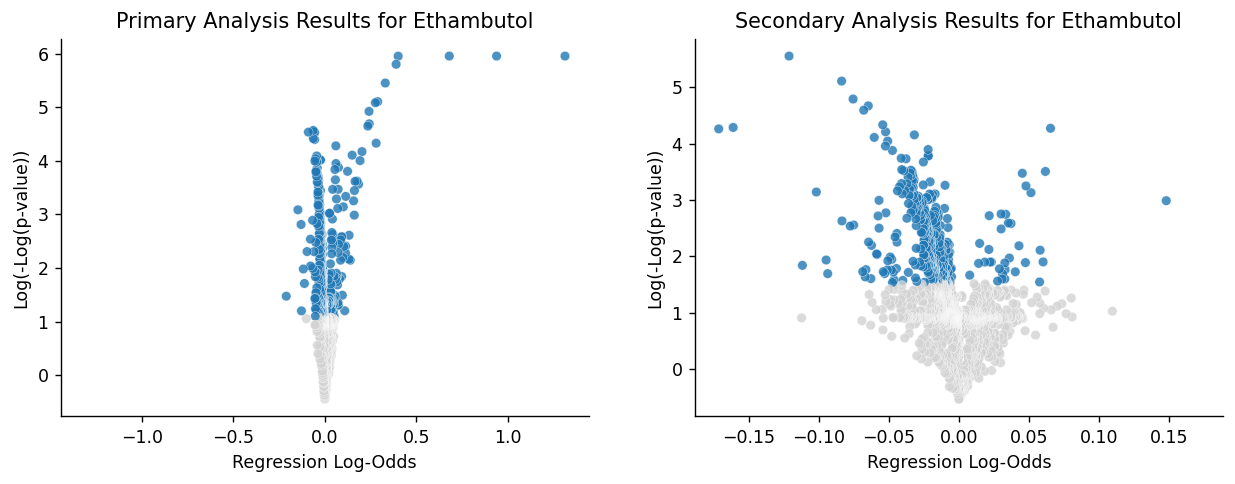

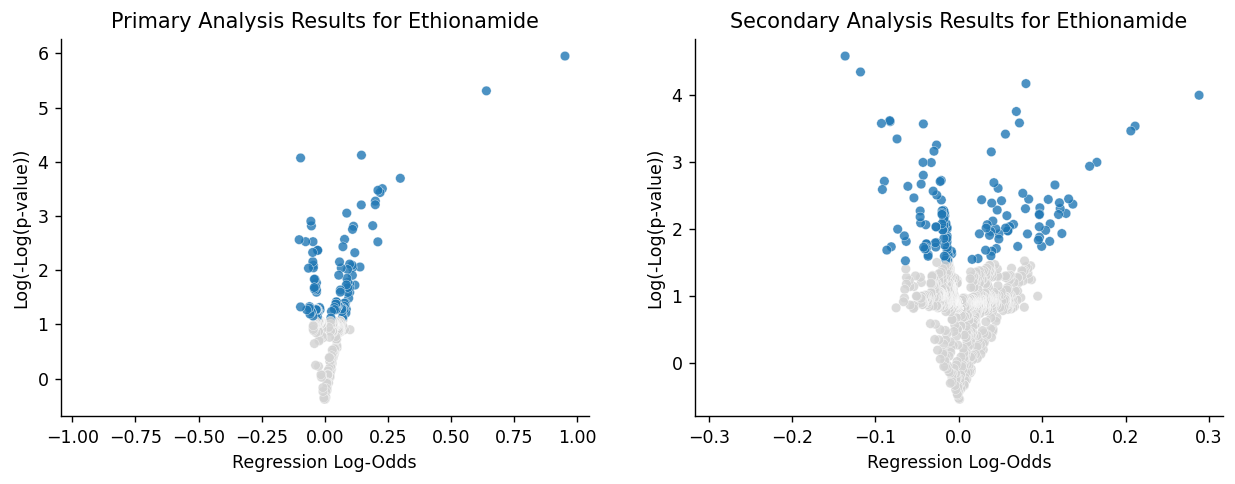

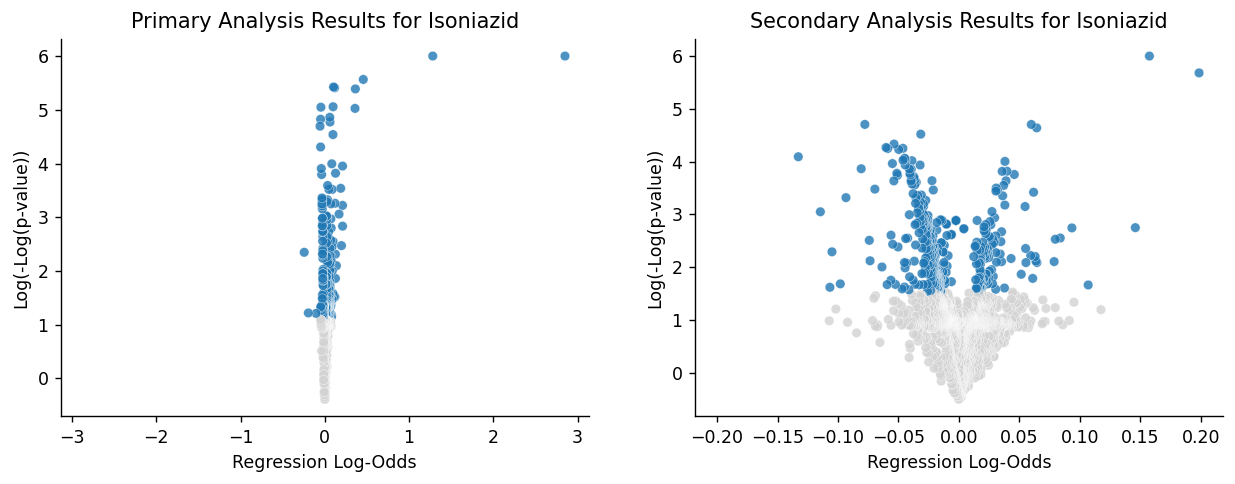

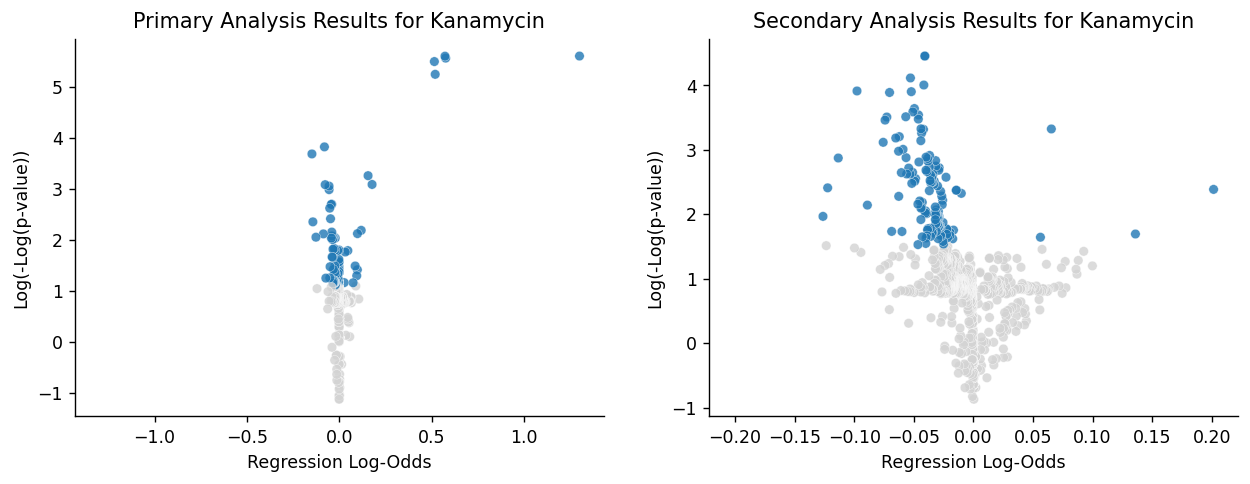

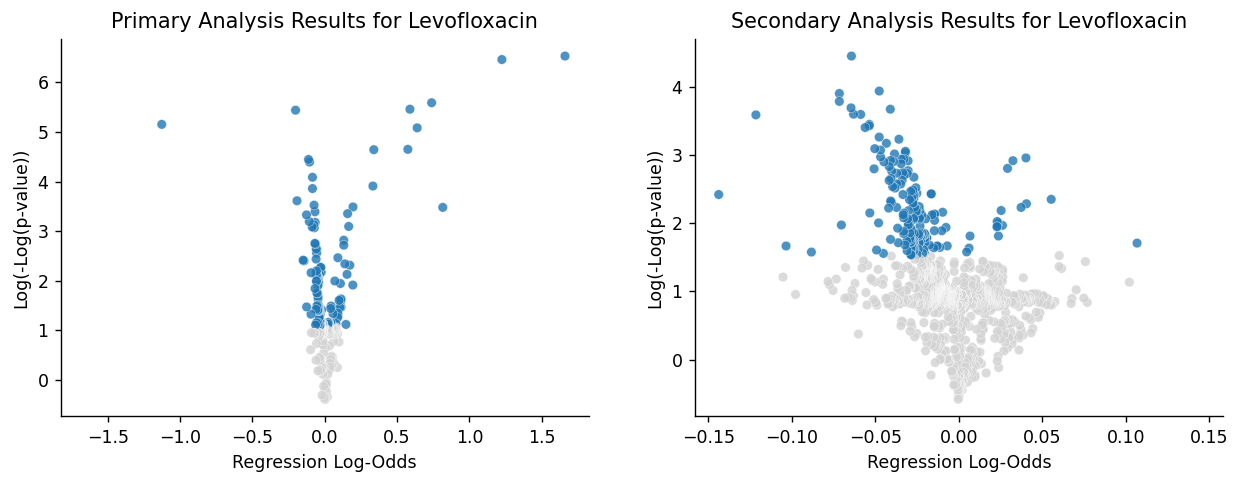

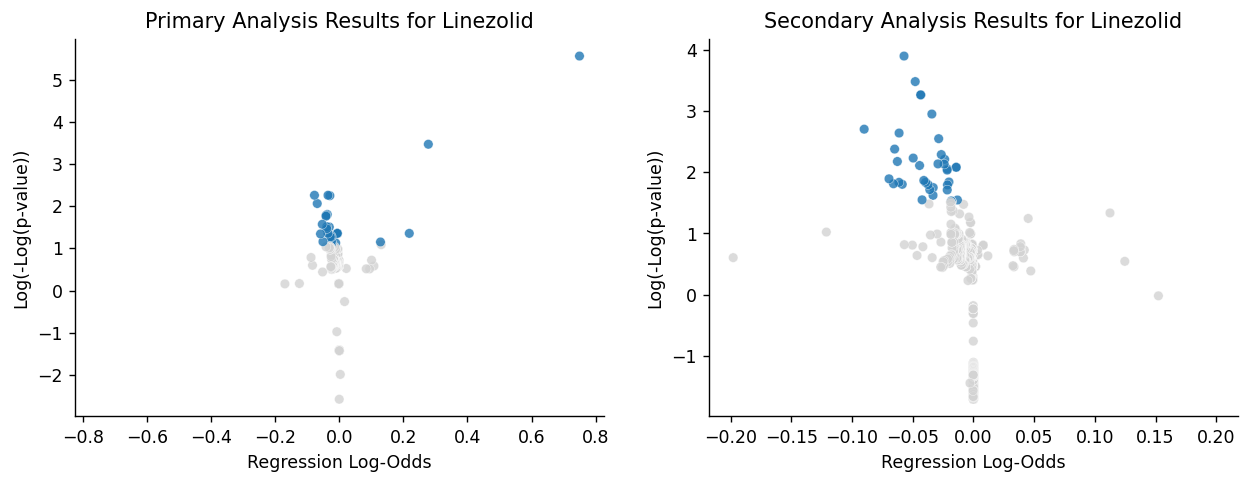

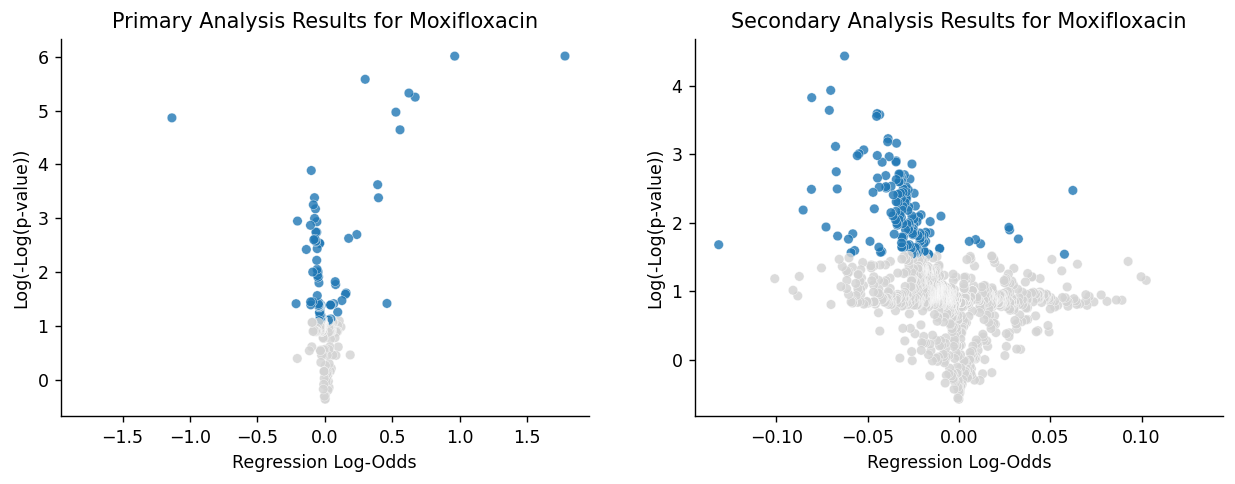

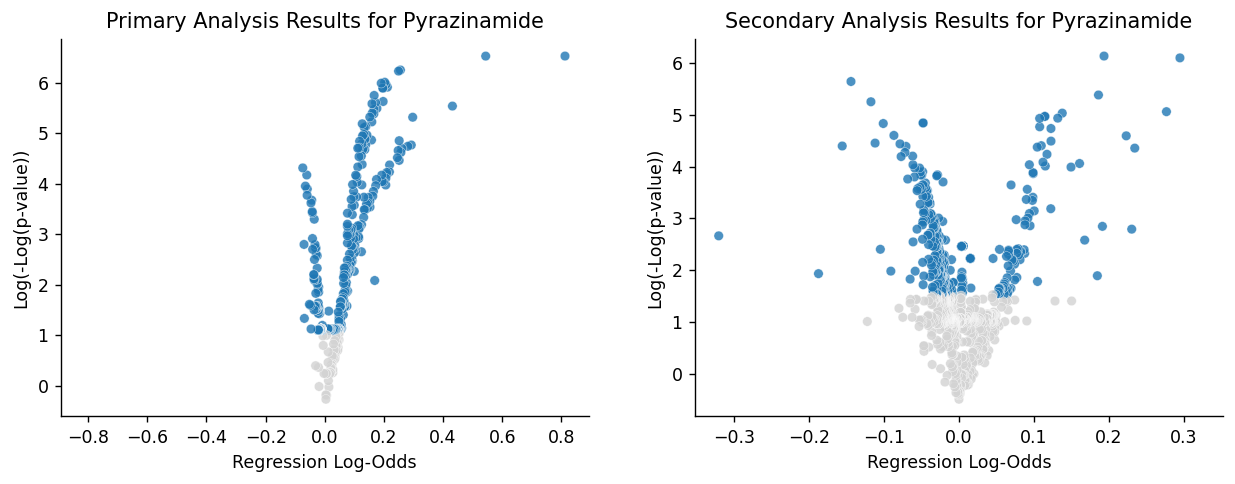

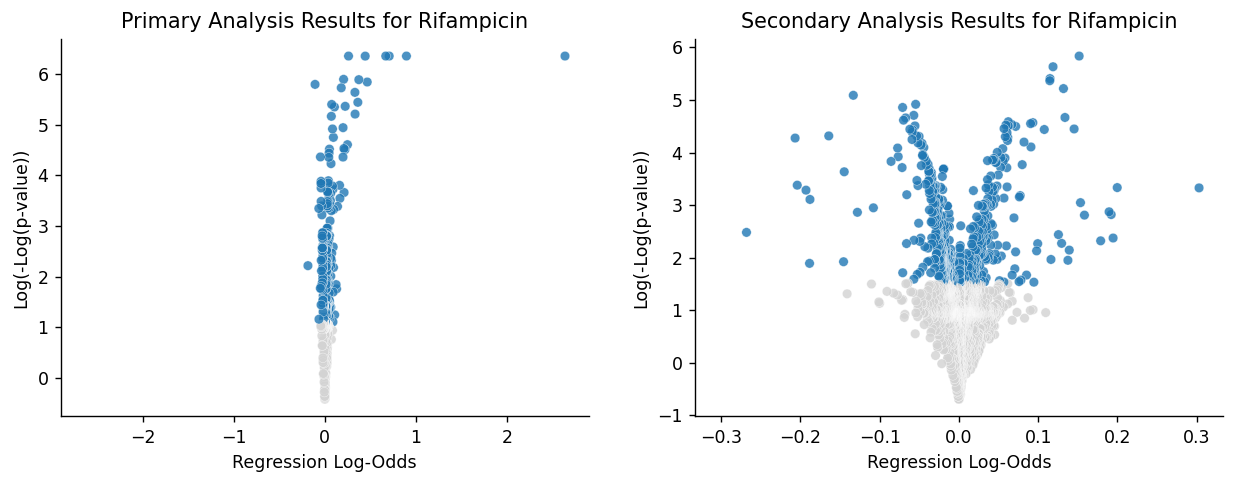

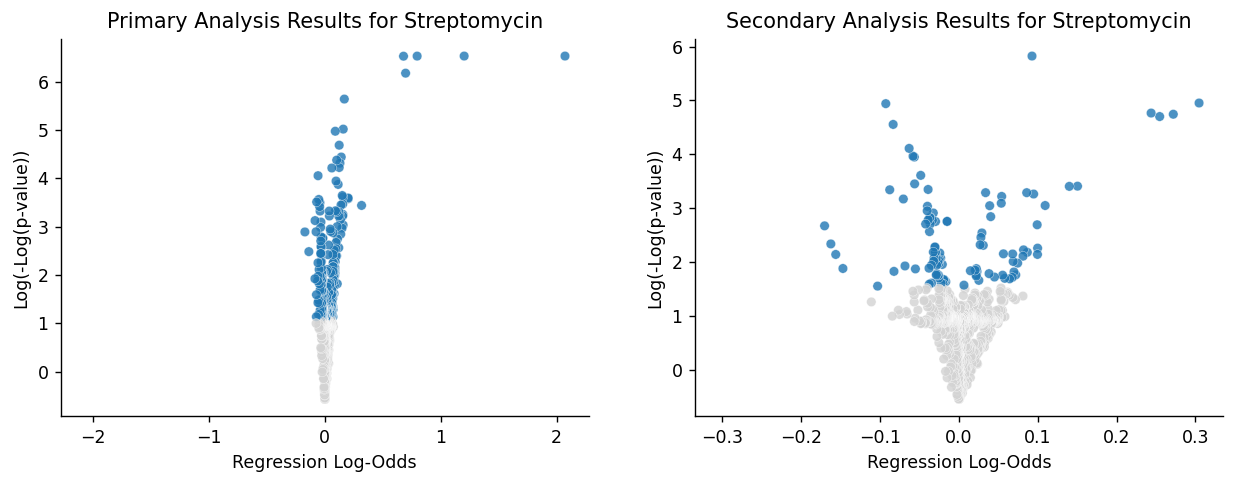

In [126]:
for drug in finished_drugs:
    _ = volcano_plot(drug_analyses[drug], drug, "log-OR", "log_neg_log_pval", "BH_pval", "Analysis", 0, saveFig=f"../results/{drug}_volcano.png")

# Analysis Summaries File

## Make an Excel file summarizing the results for each drug

In [219]:
analyses = pd.read_excel("../results/Farhat_logReg_analysis.xlsx", sheet_name=None)

all_permutations = list(itertools.product(*[[1, 0], [1, 0], [1, 0]]))
all_permutations = np.array([np.array(array) for array in all_permutations])
all_permutations

array([[1, 1, 1],
       [1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

In [214]:
def generate_summary_data(drug, excel_file_dict, all_permutations):
    
    df = excel_file_dict[drug]
    
    # annotation for primary vs. secondary analysis
    df.loc[(df["Tier"] == 1) & 
           (df["Phenos"] == 'WHO') & 
           (df["unpooled"] == 0) & 
           (df["synonymous"] == 0) &
           (df["HET"] == 'DROP'), "Primary_Analysis"
           ] = 1

    df["Primary_Analysis"] = df["Primary_Analysis"].fillna(0).astype(int)
    
    # OR > 1 or OR < 1 --> associated with resistance or susceptibility
    df["Assoc_Resistance"] = (df["Odds_Ratio"] > 1).astype(int)
    
    summary = pd.DataFrame(df.groupby(["Primary_Analysis", "Assoc_Resistance"]).Significant.value_counts())
    summary.columns = ["Count"]
    summary = summary.reset_index()
    summary = summary.sort_values(by=["Significant", "Assoc_Resistance", "Primary_Analysis"], ascending=False)
    
    # rearrange columns
    summary = summary[summary.columns[::-1]].reset_index(drop=True)

    # add rows with count = 0 if not all 8 rows are in the table
    while len(summary) < len(all_permutations):
        for i, row in summary.iterrows():
            if sum(row[["Significant", "Assoc_Resistance", "Primary_Analysis"]].values != all_permutations[i]) > 0:

                add_df = pd.DataFrame({"Count": 0}, index=[i])
                add_df[["Significant", "Assoc_Resistance", "Primary_Analysis"]] = all_permutations[i]

                summary = pd.concat([summary, add_df], axis=0)
                summary = summary.sort_values(by=["Significant", "Assoc_Resistance", "Primary_Analysis"], ascending=False).reset_index(drop=True)
                break
                
    return summary

In [223]:
analysis_summaries = {}

for drug in np.sort(finished_drugs):
    analysis_summaries[drug] = generate_summary_data(drug, analyses, all_permutations)
    
# write results to an Excel file, where each sheet name is a drug
with pd.ExcelWriter("../results/Farhat_analysis_summaries.xlsx") as file:
   
    for key, val in analysis_summaries.items():
        val.to_excel(file, sheet_name=key, index=False)

# TODO: Get model metrics for every drug, and write them to a single CSV

In [3]:
results_df = pd.DataFrame(columns=["Drug", "Sensitivity", "Sens_Lower", "Sens_Upper", "Specificity", "Spec_Lower", "Spec_Upper", 
                                   "accuracy", "accuracy_Lower", "accuracy_Upper", "AUC", "AUC_Lower", "AUC_Upper"]).set_index("Drug")

def get_model_summary(drug, analyses_dict, results_df):
    
    var_lst = ["Sens", "Spec", "AUC", "accuracy"]
    name_lst = ["Sensitivity", "Specificity", "AUC", "accuracy"]
    summary_df = analyses_dict[drug]    
    
    # add the actual values
    results_df.loc[drug, name_lst] = summary_df.query("BS==0")[var_lst].values[0]
    
    # add the confidence intervals
    for i, variable in enumerate(var_lst):
        lower, upper = np.percentile(summary_df.query("BS==1")[variable], q=[2.5, 97.5])
        results_df.loc[drug, [variable + "_Lower", variable + "_Upper"]] = [lower, upper]
        assert lower <= results_df.loc[drug, name_lst[i]]
        assert upper >= results_df.loc[drug, name_lst[i]]
    
    return results_df

In [4]:
analyses_dict = {}
for drug in os.listdir(analysis_dir):
    
    if os.path.isfile(os.path.join(analysis_dir, drug, "core_logReg_summary.csv")):
        df = pd.read_csv(os.path.join(analysis_dir, drug, "core_logReg_summary.csv"))
        if len(df) == 1001:
            analyses_dict[drug] = df
            
for drug in list(analyses_dict.keys()):
    results_df = get_model_summary(drug, analyses_dict, results_df)

In [5]:
results_df

,Sensitivity,Sens_Lower,Sens_Upper,Specificity,Spec_Lower,Spec_Upper,accuracy,accuracy_Lower,accuracy_Upper,AUC,AUC_Lower,AUC_Upper
Drug,,,,,,,,,,,,
Levofloxacin,0.8918,0.8800,0.9046,0.9650,0.9608,0.9703,0.9490,0.9451,0.9536,0.9284,0.9226,0.9350
Pyrazinamide,0.6408,0.5890,0.6601,0.7641,0.7496,0.8084,0.7406,0.7296,0.7671,0.7025,0.6929,0.7106
Streptomycin,0.8995,0.8910,0.9188,0.9529,0.9343,0.9627,0.9312,0.9263,0.9357,0.9262,0.9231,0.9310
Amikacin,0.7620,0.7364,0.7923,0.9738,0.9551,0.9784,0.9459,0.9318,0.9518,0.8679,0.8554,0.8827
Ethambutol,0.7297,0.5315,0.7454,0.7749,0.7624,0.9686,0.7659,0.7589,0.8829,0.7523,0.7471,0.7751
Clofazimine,0.7674,0.6473,0.8261,0.6644,0.6463,0.7921,0.6689,0.6515,0.7865,0.7159,0.6906,0.7488
Linezolid,0.7917,0.7017,0.8596,0.9519,0.9335,0.9970,0.9488,0.9314,0.9930,0.8718,0.8354,0.9103
Moxifloxacin,0.9233,0.9093,0.9351,0.9424,0.9375,0.9515,0.9384,0.9337,0.9452,0.9329,0.9259,0.9398
Kanamycin,0.8118,0.7872,0.8315,0.9400,0.9337,0.9513,0.9132,0.9069,0.9220,0.8759,0.8647,0.8872
